# <div align="center">SDP - Systèmes de décision</div>

### <div align="center">01-02-2025</div>

- Kiyoshi Araki

- GabrielSouza

- Lucas Tramonte


## Libraries

In [35]:
import numpy as np
import pandas as pd 
import csv
from collections import OrderedDict
import matplotlib.pyplot as plt
import random
%matplotlib inline
from gurobipy import *

## Data processing

In [36]:
number_of_bricks = 22
number_of_sr = 4

# Current Structure of Sales Territories :
sr_assignments_current = [(1, 4,  [4, 5, 6, 7, 8, 15]),
          (2, 14, [10, 11, 12, 13, 14]),
          (3, 16, [9, 16, 17, 18]),
          (4, 22, [1, 2, 3, 19, 20, 21, 22])    
         ]

In [37]:
bricks_index_values_file = "Assets/Data/bricks_index_values.csv"

# brick_workloads : dict[int : float] : associates a brick identifier j with its new index value v_j.
brick_workloads = dict()

# Loading data
with open(bricks_index_values_file) as bricksIndexValuesFile:
    reader = csv.DictReader(bricksIndexValuesFile)
    for row in reader:
        b = int(row['brick'])
        brick_workloads[b] = float(row['index_value'])
        
brick_rp_distances_file = "Assets/Data/brick_rp_distances.csv"

# distance_sr_brick : dict[(int, int) : float] : associates with the pair (i, j) of RP and brick identifiers, the distance separating i's office from the j brick
distance_sr_brick = dict()

# Loading data
with open(brick_rp_distances_file) as brickRpDistancesFile:
    reader = csv.DictReader(brickRpDistancesFile)
    for row in reader:
        b = int(row['brick'])
        for rpId in range(1, number_of_sr + 1):
            distance_sr_brick[(rpId, b)] = float(row[f'rp{rpId}'])

In [38]:
SR_set = set()
Center_Brick_Set = set()
Brick_List = list()

for rp, center_brick, bricks_assigned in sr_assignments_current:
    print(f'SR {rp}', f'Center Brick {center_brick}', f'Bricks assigned', *bricks_assigned)
    SR_set.add(rp)
    Center_Brick_Set.add(center_brick)
    Brick_List += bricks_assigned

Brick_List.sort()
assert Brick_List == list(range(1, number_of_bricks + 1))
assert Center_Brick_Set - set(Brick_List) == set()
assert SR_set == set(range(1, number_of_sr + 1))

SR 1 Center Brick 4 Bricks assigned 4 5 6 7 8 15
SR 2 Center Brick 14 Bricks assigned 10 11 12 13 14
SR 3 Center Brick 16 Bricks assigned 9 16 17 18
SR 4 Center Brick 22 Bricks assigned 1 2 3 19 20 21 22


In [39]:
assert brick_workloads[4] == 0.1516
assert brick_workloads[22] == 0.2531
assert distance_sr_brick[(1, 1)] == 16.16
assert distance_sr_brick[(2, 15)] == 2.32
assert distance_sr_brick[(3, 16)] == 0.00

# Step 1

## **Exercise**: 
Formulate and implement two mono-objective linear optimization models to solve the assignment problem using a distance and a disruption objective. Solve the instance with 22 Bricks and 4 Sales Representatives

Workload of each SR in the current solution for the new $v_j$ index values

In [40]:
SR = {} 
for j in range(0, number_of_sr):
    LinExpr = quicksum(brick_workloads[i] for i in sr_assignments_current[j][2]) 
    SR[f'SR{j+1}'] = round(LinExpr.getValue(),3)
    
SR_data = pd.DataFrame(list(SR.items()), columns=['i', 'Workload'])
SR_data

,i,Workload
0,SR1,0.951
1,SR2,1.338
2,SR3,0.705
3,SR4,1.007


In [41]:
# Define problem variables 

# -- Model initialization --
m = Model("rendu")

# Xij : dict[(int, int) : Var] : Assignment of brig j to SR office i
Xij = {(i, j) : m.addVar(vtype = GRB.BINARY, name=f'x_{i}_{j}') for i in range(1, number_of_sr + 1) for j in range(1, number_of_bricks + 1)}

Constraints

- Each brick is assigned to a single SR

$$\sum_{i = 1}^{4} x_{ij} = 1 \;\;\;\; \text{for all $j = 1 \dots 22$} \;\;\;$$

In [42]:
CONSTR = {j : m.addConstr(quicksum(Xij[(i,j)] for i in range(1, number_of_sr + 1)) == 1, name = f'Constr{j}') for j in range(1, number_of_bricks + 1)}

- Each SR has a workload in the interval $[0.8, 1.2]$.

$$\sum_{j = 1}^{22} x_{ij}v_{j} \leq 1.2 \;\;\;\; \text{for all $i = 1\dots 4$} \;\;\;$$

$$\sum_{j = 1}^{22} x_{ij}v_{j} \geq 0.8 \;\;\;\; \text{for all $i = 1\dots 4$} \;\;\;$$

In [43]:
CHARGEINF = {i : m.addConstr(quicksum(Xij[(i,j)]*brick_workloads[j] for j in range(1, number_of_bricks + 1)) >= 0.8, name = f'Charge_inf{i}') for i in range(1, number_of_sr + 1)}
CHARGESUP = {i : m.addConstr(quicksum(Xij[(i,j)]*brick_workloads[j] for j in range(1, number_of_bricks + 1)) <= 1.2, name = f'Charge_sup{i}') for i in range(1, number_of_sr + 1)}

Define the objective of minimizing the total travel distance of all SRs.

$$\text{Minimize} \;\;\; \sum_{i = 1}^{4}\sum_{j = 1}^{22} x_{ij}d_{ij}$$

In [44]:
z1 = quicksum(Xij[(i,j)]*distance_sr_brick[(i,j)] for i in range(1, number_of_sr + 1) for j in range(1, number_of_bricks + 1))
# -- Objective function added --
m.setObjective(z1, GRB.MINIMIZE)
m.params.outputflag = 0 # mute mode

# -- Model update --
m.update()
display(m)

<gurobi.Model MIP instance rendu: 30 constrs, 88 vars, Parameter changes: Username=(user-defined), OutputFlag=0>

In [45]:
# -- Resolution --
m.optimize()

# Objective function value
print(f'z* = {round(m.objVal, 3)} km')

print('\n')

#Measure load and distance
Distance = {i : quicksum([distance_sr_brick[(i, j)]*Xij[(i, j)] for j in range(1, number_of_bricks + 1)]) for i in range(1, number_of_sr + 1)}
Charge  = {i : quicksum([brick_workloads[j]*Xij[(i, j)] for j in range(1, number_of_bricks + 1)]) for i in range(1, number_of_sr + 1)}

df = pd.DataFrame([
    {
        "SR": SR,
        "SR Office": SR_OFFICE,
        "Bricks allocated": [j for j in range(1, number_of_bricks + 1) if round(Xij[(SR, j)].x) == 1],
        "Workload": round(Charge[SR].getValue(), 3),
        "Distance covered (km)": round(Distance[SR].getValue(),3),
    }
    for SR, SR_OFFICE, BRICKS in sr_assignments_current 
])

df

z* = 154.62 km




,SR,SR Office,Bricks allocated,Workload,Distance covered (km)
0,1,4,"[4, 5, 6, 7, 8, 9, 12, 19, 20]",1.038,64.37
1,2,14,"[11, 13, 14, 18]",1.045,7.56
2,3,16,"[10, 15, 16, 17]",1.115,6.56
3,4,22,"[1, 2, 3, 21, 22]",0.803,76.13


Define the objective function to minimize the weighted disturbance in percent (%).

$$\text{Minimize} \;\;\; 100\frac{\sum_{i = 1}^{4} \sum_{j = 1}^{22} x_{ij}v_j(1 - x_{ij}^*)}{\sum_{j = 1}^{22} v_j}$$

current assignment:
$$ x_{ij}^*  \;\;\; $$     

In [46]:
current_assignment = {(i, j) : 0 for i in range(1, number_of_sr + 1) for j in range(1, number_of_bricks + 1)}
for SR, BSR_OFFICE, BRICKS in sr_assignments_current:
    value = 0
    for brick in BRICKS:
        current_assignment[(SR, brick)] = 1
        value += brick_workloads[brick]
        

z2 = 100 * quicksum([brick_workloads[j]*(1 - current_assignment[(i, j)])*Xij[(i, j)] for i in range(1, number_of_sr + 1) for j in range(1, number_of_bricks + 1)]) / sum(brick_workloads.values())

print("The value of the weighted disturbance generated by the optimal solution is {} %.".format(round(z2.getValue(),3)))

The value of the weighted disturbance generated by the optimal solution is 30.138 %.


In [47]:
m.setObjective(z2, GRB.MINIMIZE)
m.params.outputflag = 0 
m.update()
m.optimize()

print(f' we obtain z* = {round(m.objVal, 3)} %  of the total disturbance ')

 we obtain z* = 4.24 %  of the total disturbance 


In [48]:
Distance = {i : quicksum([distance_sr_brick[(i, j)]*Xij[(i, j)] for j in range(1, number_of_bricks + 1)]) for i in range(1, number_of_sr + 1)}
Charge  = {i : quicksum([brick_workloads[j]*Xij[(i, j)] for j in range(1, number_of_bricks + 1)]) for i in range(1, number_of_sr + 1)}

df = pd.DataFrame([
    {
        "SR": SR,
        "SR Office": SR_OFFICE,
        "Bricks allocated": [j for j in range(1, number_of_bricks + 1) if round(Xij[(SR, j)].x) == 1],
        "Workload": round(Charge[SR].getValue(), 3),
        "Distance covered (km)": round(Distance[SR].getValue(),3),
    }
    for SR, SR_OFFICE, BRICKS in sr_assignments_current 
])

df


,SR,SR Office,Bricks allocated,Workload,Distance covered (km)
0,1,4,"[4, 5, 6, 7, 8, 15]",0.951,19.30
1,2,14,"[10, 13, 14]",1.168,7.79
2,3,16,"[9, 11, 12, 16, 17, 18]",0.874,37.06
3,4,22,"[1, 2, 3, 19, 20, 21, 22]",1.007,124.74


In [49]:
print(df['Distance covered (km)'].sum(), 'km')

188.89 km


Reducing the weighted loss increases the total distance covered by the RP:

Minimization of total distance = (154.62, 30.138 )


Minimization of weighted disturbance = (188.89, 4.24)

### Implement the epsilon-constraint scheme to compute the set of all non-dominated solutions

$$\epsilon = 0.001$$

$$\alpha = 0$$

In [50]:
columns = ["Iteration", "First Objective", "Second Objective", "SR", "SR OFFICE", "Bricks allocated", "Workload", "Distance (km)"]
df_iterations = pd.DataFrame(columns=columns)


alpha = 0
epsilon = 0.001 

EpsilonDict = dict()

m.setObjective(z1 + alpha*z2, GRB.MINIMIZE)
m.params.outputflag = 0 
m.update()
m.optimize()

it = 0
while m.status != GRB.INFEASIBLE:

    row = { 
        "Iteration": it,
        "First Objective": round(m.objVal, 3),
        "Second Objective": round(z2.getValue(), 3)
    }

    for SR, SR_OFFICE, BRICKS in sr_assignments_current: 
        row["SR"] = SR
        row["SR OFFICE"] = SR_OFFICE
        row["Bricks allocated"] = [j for j in range(1, number_of_bricks + 1) if round(Xij[(SR, j)].x) == 1]
        row["Workload"] = round(Charge[SR].getValue(), 3)
        row["Distance (km)"] = round(Distance[SR].getValue(), 3)

        df_iterations = pd.concat([df_iterations, pd.DataFrame([row])], ignore_index=True)

    it += 1
    EpsilonDict[it] = m.addConstr(z2 <= z2.getValue() - epsilon, name=f'epsilon_{it}')
    m.update()
    m.optimize()

df_iterations

C:\Users\lucas\AppData\Local\Temp\ipykernel_20384\3034799165.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_iterations = pd.concat([df_iterations, pd.DataFrame([row])], ignore_index=True)


,Iteration,First Objective,Second Objective,SR,SR OFFICE,Bricks allocated,Workload,Distance (km)
0,0,154.62,30.138,1,4,"[4, 5, 6, 7, 8, 9, 12, 19, 20]",1.038,64.37
1,0,154.62,30.138,2,14,"[11, 13, 14, 18]",1.045,7.56
2,0,154.62,30.138,3,16,"[10, 15, 16, 17]",1.115,6.56
3,0,154.62,30.138,4,22,"[1, 2, 3, 21, 22]",0.803,76.13
4,1,154.64,28.068,1,4,"[4, 5, 6, 7, 8, 9, 19, 20]",0.955,42.38
...,...,...,...,...,...,...,...,...
75,18,188.13,5.675,4,22,"[1, 2, 3, 19, 20, 21, 22]",1.007,124.74
76,19,188.89,4.240,1,4,"[4, 5, 6, 7, 8, 15]",0.951,19.30
77,19,188.89,4.240,2,14,"[10, 13, 14]",1.168,7.79
78,19,188.89,4.240,3,16,"[9, 11, 12, 16, 17, 18]",0.874,37.06


## Compute and represent the corresponding sets of non-dominated solutions for the 4x22 problem, with interval workload constraints [0.8, 1.2], [0.85, 1.15], and [0.9, 1.1],

In [51]:
Distance_totale = df_iterations['First Objective'].to_list()
Pertubation_ponderee = df_iterations['Second Objective'].to_list()

solutions_efficaces = list(zip(Distance_totale, Pertubation_ponderee)) # aggregating lists
Liste_solutions_efficaces = list(OrderedDict.fromkeys(solutions_efficaces)) # maintains the sequence in which keys are added
Liste_solutions_efficaces

[(154.62, 30.138),
 (154.64, 28.068),
 (154.99, 24.917),
 (160.58, 24.062),
 (160.71, 22.425),
 (163.35, 21.062),
 (164.57, 20.695),
 (164.64, 19.895),
 (165.9, 14.66),
 (166.44, 12.49),
 (167.21, 11.422),
 (168.14, 10.775),
 (168.9, 9.34),
 (172.93, 8.93),
 (173.86, 8.282),
 (174.62, 6.848),
 (183.17, 6.732),
 (187.2, 6.323),
 (188.13, 5.675),
 (188.89, 4.24)]

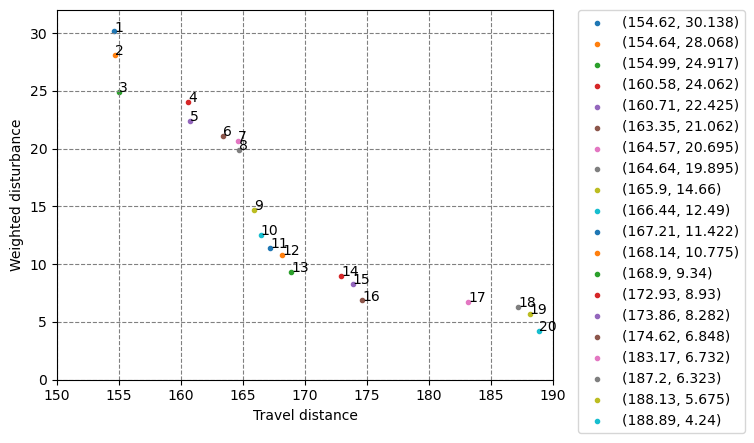

In [52]:
# Z1 : List[float]
Z1 = [sol[0] for sol in Liste_solutions_efficaces]
#Z2 : List[float]
Z2 = [sol[1] for sol in Liste_solutions_efficaces]

k = 1
for i, j in zip(Z1, Z2):
    plt.scatter(i, j, marker='.', label=str((i,j)))
    plt.annotate(str(k), (i, j))
    k += 1

plt.grid(linestyle='--', color='gray')
plt.xlim((150, 190)) 
plt.ylim((0.0, 32))

plt.xlabel('Travel distance')
plt.ylabel('Weighted disturbance')
plt.legend(bbox_to_anchor = (1.05, 1), loc = 2, borderaxespad = 0.)

<font color="blue">
  <div align="center">There are exactly</div>
</font>

<div align="center">6 supported solutions.</div>
<div align="justify">These are 1, 2, 3, 13, 16, 20</div>

It is important to note that the old solution 13 was removed, but index 13 was reassigned to the next solution.  
To avoid confusion, the solution `(168.91, 9.707)` is not efficient and has not been included.  
The solution that moved from index 14 to index 13 is `(168.9, 9.34)`, and it is a supported solution.


Calculate the set of non-dominated solutions if we now limit the workload of each SR to the interval $[0.9, 1.1]$.

In [53]:
for cs in CHARGESUP.values():
    cs.RHS = 1.1
    
for ci in CHARGEINF.values():
    ci.RHS = 0.9

for e in EpsilonDict.values():
    m.remove(e)
    
m.update()

columns = ["Iteration", "First Objective", "Second Objective", "SR", "SR_OFFICE", "Bricks Allocated", "Workload", "Distance (km)"]
df_iterations = pd.DataFrame(columns=columns)

m.optimize()

it = 0
while m.status != GRB.INFEASIBLE:

    row = {
        "Iteration": it,
        "First Objective": round(m.objVal, 3),
        "Second Objective": round(z2.getValue(), 3)
    }

    for SR, BUREAU_SR, BRICKS in sr_assignments_current:
        row["SR"] = SR
        row["SR_OFFICE"] = SR_OFFICE
        row["Bricks Allocated"] = [j for j in range(1, number_of_bricks + 1) if round(Xij[(SR, j)].x) == 1]
        row["Workload"] = round(Charge[SR].getValue(), 3)
        row["Distance (km)"] = round(Distance[SR].getValue(), 3)

        df_iterations = pd.concat([df_iterations, pd.DataFrame([row])], ignore_index=True)

    it += 1
    EpsilonDict[it] = m.addConstr(z2 <= z2.getValue() - epsilon, name=f'epsilon_{it}')
    m.update()
    m.optimize()

df_iterations

C:\Users\lucas\AppData\Local\Temp\ipykernel_20384\942549307.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_iterations = pd.concat([df_iterations, pd.DataFrame([row])], ignore_index=True)


,Iteration,First Objective,Second Objective,SR,SR_OFFICE,Bricks Allocated,Workload,Distance (km)
0,0,162.43,28.352,1,22,"[4, 5, 6, 7, 8, 9, 12, 19]",0.938,46.88
1,0,162.43,28.352,2,22,"[11, 13, 14, 17]",1.073,9.19
2,0,162.43,28.352,3,22,"[10, 15, 16, 18]",1.087,7.02
3,0,162.43,28.352,4,22,"[1, 2, 3, 20, 21, 22]",0.902,99.34
4,1,162.81,24.862,1,22,"[4, 5, 6, 7, 8, 9, 12, 19]",0.938,46.88
5,1,162.81,24.862,2,22,"[10, 14]",1.071,4.51
6,1,162.81,24.862,3,22,"[11, 13, 15, 16, 17, 18]",1.089,12.08
7,1,162.81,24.862,4,22,"[1, 2, 3, 20, 21, 22]",0.902,99.34
8,2,171.36,24.747,1,22,"[4, 5, 6, 7, 8, 9, 12, 20]",0.933,53.24
9,2,171.36,24.747,2,22,"[10, 14]",1.071,4.51


In [54]:
Distance_totale = df_iterations['First Objective'].to_list()
Pertubation_ponderee = df_iterations['Second Objective'].to_list()

solutions_efficaces = list(zip(Distance_totale, Pertubation_ponderee))
Liste_solutions_efficaces_q12 = list(OrderedDict.fromkeys(solutions_efficaces))
Liste_solutions_efficaces_q12

[(162.43, 28.352),
 (162.81, 24.862),
 (171.36, 24.747),
 (171.62, 12.168),
 (172.39, 11.1),
 (172.93, 8.93),
 (181.48, 8.815),
 (186.66, 8.492),
 (187.18, 8.393),
 (187.2, 6.323)]

Represent these solutions in bi-criteria space.

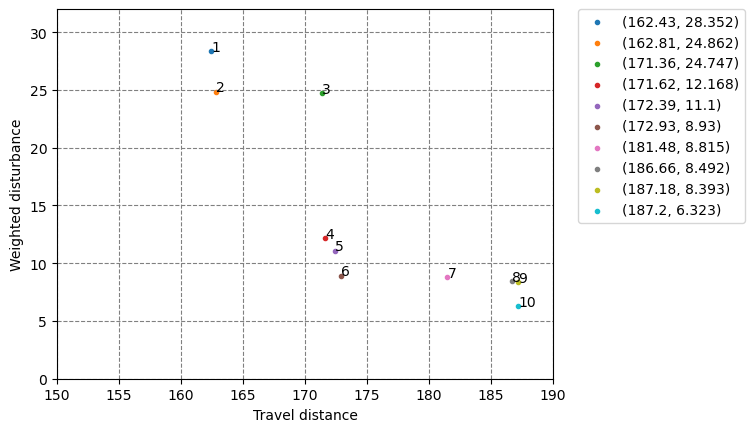

In [55]:
# Z1 : List[float]
Z1 = [sol[0] for sol in Liste_solutions_efficaces_q12]
#Z2 : List[float]
Z2 = [sol[1] for sol in Liste_solutions_efficaces_q12]

k = 1
for i, j in zip(Z1, Z2):
    plt.scatter(i, j, marker='.', label=str((i,j)))
    plt.annotate(str(k), (i, j))
    k += 1

plt.grid(linestyle='--', color='gray')
plt.xlim((150, 190)) 
plt.ylim((0.0, 32))

plt.xlabel('Travel distance')
plt.ylabel('Weighted disturbance')
plt.legend(bbox_to_anchor = (1.05, 1), loc = 2, borderaxespad = 0.)

Calculate the set of non-dominated solutions if we now limit the workload of each SR to the interval $[0.85, 1.15]$.

In [56]:
for cs in CHARGESUP.values():
    cs.RHS = 1.15
    
for ci in CHARGEINF.values():
    ci.RHS = 0.85

for e in EpsilonDict.values():
    m.remove(e)
    
m.update()

columns = ["Iteration", "First Objective", "Second Objective", "SR", "SR_OFFICE", "Bricks Allocated", "Workload", "Distance (km)"]
df_iterations = pd.DataFrame(columns=columns)

m.optimize()

it = 0
while m.status != GRB.INFEASIBLE:

    row = {
        "Iteration": it,
        "First Objective": round(m.objVal, 3),
        "Second Objective": round(z2.getValue(), 3)
    }

    for SR, BUREAU_SR, BRICKS in sr_assignments_current:
        row["SR"] = SR
        row["SR_OFFICE"] = SR_OFFICE
        row["Bricks Allocated"] = [j for j in range(1, number_of_bricks + 1) if round(Xij[(SR, j)].x) == 1]
        row["Workload"] = round(Charge[SR].getValue(), 3)
        row["Distance (km)"] = round(Distance[SR].getValue(), 3)

        df_iterations = pd.concat([df_iterations, pd.DataFrame([row])], ignore_index=True)

    it += 1
    EpsilonDict[it] = m.addConstr(z2 <= z2.getValue() - epsilon, name=f'epsilon_{it}')
    m.update()
    m.optimize()

df_iterations

C:\Users\lucas\AppData\Local\Temp\ipykernel_20384\3950715657.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_iterations = pd.concat([df_iterations, pd.DataFrame([row])], ignore_index=True)


,Iteration,First Objective,Second Objective,SR,SR_OFFICE,Bricks Allocated,Workload,Distance (km)
0,0,160.34,27.645,1,22,"[4, 5, 6, 7, 8, 9, 12, 19]",0.938,46.88
1,0,160.34,27.645,2,22,"[11, 13, 14, 18]",1.045,7.56
2,0,160.34,27.645,3,22,"[10, 15, 16, 17]",1.115,6.56
3,0,160.34,27.645,4,22,"[1, 2, 3, 20, 21, 22]",0.902,99.34
4,1,160.36,25.575,1,22,"[4, 5, 6, 7, 8, 9, 19]",0.855,24.89
5,1,160.36,25.575,2,22,"[11, 12, 13, 14, 18]",1.127,29.57
6,1,160.36,25.575,3,22,"[10, 15, 16, 17]",1.115,6.56
7,1,160.36,25.575,4,22,"[1, 2, 3, 20, 21, 22]",0.902,99.34
8,2,162.81,24.862,1,22,"[4, 5, 6, 7, 8, 9, 12, 19]",0.938,46.88
9,2,162.81,24.862,2,22,"[10, 14]",1.071,4.51


In [57]:
Distance_totale = df_iterations['First Objective'].to_list()
Pertubation_ponderee = df_iterations['Second Objective'].to_list()

solutions_efficaces = list(zip(Distance_totale, Pertubation_ponderee))
Liste_solutions_efficaces_q12 = list(OrderedDict.fromkeys(solutions_efficaces))
Liste_solutions_efficaces_q12

[(160.34, 27.645),
 (160.36, 25.575),
 (162.81, 24.862),
 (169.11, 24.508),
 (171.6, 14.238),
 (171.62, 12.168),
 (172.14, 12.068),
 (172.16, 9.998),
 (172.93, 8.93),
 (181.48, 8.815),
 (186.43, 7.39),
 (187.2, 6.323)]

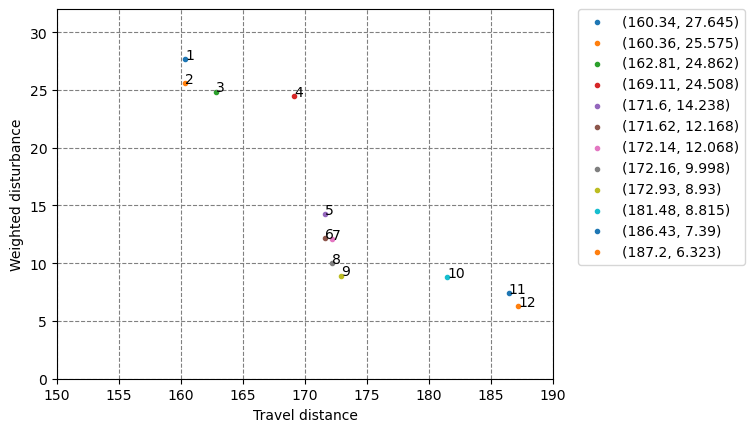

In [58]:
# Z1 : List[float]
Z1 = [sol[0] for sol in Liste_solutions_efficaces_q12]
#Z2 : List[float]
Z2 = [sol[1] for sol in Liste_solutions_efficaces_q12]

k = 1
for i, j in zip(Z1, Z2):
    plt.scatter(i, j, marker='.', label=str((i,j)))
    plt.annotate(str(k), (i, j))
    k += 1

plt.grid(linestyle='--', color='gray')
plt.xlim((150, 190)) 
plt.ylim((0.0, 32))

plt.xlabel('Travel distance')
plt.ylabel('Weighted disturbance')
plt.legend(bbox_to_anchor = (1.05, 1), loc = 2, borderaxespad = 0.)

# Step 2

## **Exercise**: 
Is your first model able to solve the 100 bricks / 10 SRs instances? compute and represent the corresponding sets of non-dominated solutions.

### Data Generation

We simulate:
- **Workloads** for bricks such that total workload is around 10.  
- **Distances** randomly between 0 and 100.  
- A **previous assignment** that splits the bricks evenly among SRs.

In [59]:
import random
import numpy as np

number_of_sr = 10
number_of_bricks = 100
workload_lower = 0.8
workload_upper = 1.2

# We want total workload ~10.
# Each brick ~0.1 workload on average.
# We'll randomly pick workloads from [0.09, 0.11] to ensure total is close to 10.
brick_workloads = {
    j: float(np.random.uniform(0.09, 0.11)) 
    for j in range(1, number_of_bricks+1)
}

# Check total workload
total_workload = sum(brick_workloads.values())
print("Total workload:", total_workload)  # Should be close to ~10

# Distances remain random, that shouldn't cause feasibility issues as long as assignments are flexible.
distance_sr_brick = {
    (i, j): float(np.random.uniform(0.0, 100.0))
    for i in range(1, number_of_sr+1)
    for j in range(1, number_of_bricks+1)
}

# For simplicity, assume a current assignment as the previous solution

current_assignment = {(i, j): 0 for i in range(1, number_of_sr+1) 
                                for j in range(1, number_of_bricks+1)}
old_assignment_list = np.array_split(range(1, number_of_bricks+1), number_of_sr)
for sr_id, bricks_list in enumerate(old_assignment_list, start=1):
    for b in bricks_list:
        current_assignment[(sr_id, b)] = 1

Total workload: 10.12383093636327


### Model Formulation

1. **Variables**:  
   $$
   X_{ij} = 
   \begin{cases}
   1 & \text{if brick } j \text{ is assigned to SR } i,\\
   0 & \text{otherwise}.
   \end{cases}
   $$

2. **Constraints**:
   - **Unique Assignment**:  
     $$
       \sum_{i=1}^{\text{SRs}} X_{ij} = 1 \quad \forall j.
     $$
   - **Workload Bounds**:  
     $$
       \text{lower} \;\le\; \sum_{j=1}^{\text{Bricks}} w_j \,X_{ij} \;\le\; \text{upper}
       \quad \forall i.
     $$

In [60]:
m = Model("scaled_instance")

# Decision variables: Xij = 1 if brick j assigned to SR i
Xij = {(i, j): m.addVar(vtype=GRB.BINARY, name=f"x_{i}_{j}")
       for i in range(1, number_of_sr+1)
       for j in range(1, number_of_bricks+1)}

m.update()

# Constraints:
# 1. Every brick is assigned to exactly one SR
for j in range(1, number_of_bricks+1):
    m.addConstr(sum(Xij[(i, j)] for i in range(1, number_of_sr+1)) >= 1, 
                name=f"assign_{j}")

# 2. Workload constraints:
for i in range(1, number_of_sr+1):
    m.addConstr(quicksum(Xij[(i,j)]*brick_workloads[j] for j in range(1, number_of_bricks+1)) >= workload_lower, 
                name=f"workload_lower_{i}")
    m.addConstr(quicksum(Xij[(i,j)]*brick_workloads[j] for j in range(1, number_of_bricks+1)) <= workload_upper, 
                name=f"workload_upper_{i}")

m.update()

### **Objectives**:
   - **Minimize distance**:  
     $$
       z_1 = \sum_{i=1}^{\text{SRs}} \sum_{j=1}^{\text{Bricks}} \text{distance}_{ij} \,X_{ij}.
     $$
   - **Minimize disturbance**:  
     $$
       z_2 = 100 \times \frac{\sum_{i,j} w_j \,(1 - \text{old\_assignment}_{ij})\,X_{ij}}{\sum_{j=1}^{\text{Bricks}} w_j}.
     $$


In [61]:
# Objective 1: Minimize total travel distance
z1 = quicksum(Xij[(i,j)] * distance_sr_brick[(i,j)] for i in range(1, number_of_sr+1) 
                                          for j in range(1, number_of_bricks+1))

# Objective 2: Minimize weighted disturbance:
# Disturbance = 100 * sum_over_i,j [v_j * (1 - x_{ij}^*) * Xij] / sum_of_vj
sum_vj = sum(brick_workloads.values())
z2 = 100 * (quicksum(brick_workloads[j]*(1 - current_assignment[(i,j)])*Xij[(i,j)]
                     for i in range(1, number_of_sr+1) 
                     for j in range(1, number_of_bricks+1)) / sum_vj)

# For demonstration, start with minimizing distance (z1):
m.setObjective(z1, GRB.MINIMIZE)

m.Params.OutputFlag = 1  # Set to 1 to see log, 0 to mute
m.optimize()

# Print Results
if m.status == GRB.OPTIMAL:
    print("\nOptimal solution found:")
    print(f"Objective (Distance): {m.objVal:.2f}")

    # Compute workloads and distances
    Distance = {i : sum(distance_sr_brick[(i,j)]*Xij[(i,j)].X for j in range(1, number_of_bricks+1))
                for i in range(1, number_of_sr+1)}
    Charge  = {i : sum(brick_workloads[j]*Xij[(i,j)].X for j in range(1, number_of_bricks+1))
                for i in range(1, number_of_sr+1)}

    solution_df = pd.DataFrame([
        {
            "SR": i,
            "Bricks Allocated": [j for j in range(1, number_of_bricks+1) if Xij[(i,j)].X > 0.5],
            "Workload": Charge[i],
            "Distance (km)": Distance[i],
        }
        for i in range(1, number_of_sr+1)
    ])
    print("\nSolution Allocation:")
    print(solution_df)

    # Compute disturbance measure for this solution
    disturbance_val = z2.getValue()
    print(f"\nWeighted Disturbance: {disturbance_val:.2f}%")

else:
    print("No optimal solution found. Status code:", m.status)

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (26100.2))

CPU model: 12th Gen Intel(R) Core(TM) i5-1235U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 120 rows, 1000 columns and 3000 nonzeros
Model fingerprint: 0x3f4391d1
Variable types: 0 continuous, 1000 integer (1000 binary)
Coefficient statistics:
  Matrix range     [9e-02, 1e+00]
  Objective range  [2e-02, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-01, 1e+00]
Found heuristic solution: objective 4999.4398308
Presolve time: 0.01s
Presolved: 120 rows, 1000 columns, 3000 nonzeros
Variable types: 0 continuous, 1000 integer (1000 binary)
Found heuristic solution: objective 3469.4300418

Root relaxation: objective 8.935869e+02, 142 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   

## **Exercise**:
How to model the case for partially assigning bricks (i.e., assign a brick to multiple SRs?). 

### **1. Partial Assignments**
In a strictly **binary** model, each brick must be assigned to exactly **one** SR. However, in practice:
- Some bricks may have a **high workload**, making it infeasible for a single SR to handle them alone.
- Allowing **fractional assignments** can improve **workload balancing** across SRs.
- This approach can lead to **shorter travel distances** if bricks are allocated **partially** to the nearest SRs instead of a single distant one.

#### **Key Differences from the Previous Binary Model**
- Instead of $ X_{ij} \in \{0,1\} $, we now allow **continuous values**:

  $$
  X_{ij} \in [0,1]
  $$

  meaning that each SR $ i $ receives a **fraction** of Brick $ j $.

- Instead of forcing **one unique** SR per brick, we now require that the **sum of fractions** equals 1:

  $$
  \sum_{i=1}^{\text{SRs}} X_{ij} = 1, \quad \forall j.
  $$

  This ensures that every brick is **fully assigned**, even though the responsibility is now split.

---

### **2. Mathematical Model Formulation**

#### **Decision Variable**
We introduce a **fractional assignment variable**:

$$
X_{ij} \in [0,1]
$$

where:
- $ X_{ij} $ represents the **fraction** of Brick $ j $ assigned to SR $ i $.
- If $ X_{ij} = 1 $, then Brick $ j $ is fully assigned to SR $ i $.
- If $ 0 < X_{ij} < 1 $, then Brick $ j $ is **shared** between multiple SRs.

#### **Constraints**
##### **1. Full Assignment of Each Brick**
Each brick must be **entirely assigned** across all SRs:

$$
\sum_{i=1}^{\text{SRs}} X_{ij} = 1, \quad \forall j.
$$

This ensures that all bricks remain **fully allocated** while allowing shared responsibility.

##### **2. Workload Balance for Each SR**
We maintain **lower and upper workload limits** for each SR:

$$
\sum_{j=1}^{\text{Bricks}} w_j \cdot X_{ij} \;\;\ge\;\;\text{lower\_workload},
\quad
\sum_{j=1}^{\text{Bricks}} w_j \cdot X_{ij} \;\;\le\;\;\text{upper\_workload}.
$$

where:
- $ w_j $ is the **workload** associated with Brick $ j $.
- $ \text{lower\_workload} $ and $ \text{upper\_workload} $ define **bounds** on how much work each SR can handle.

These constraints prevent **overloading** or **underutilizing** SRs.

---

### **3. Objectives**

We define **two competing objectives**: **minimizing total travel distance** and **minimizing disruption** in assignments.

#### **Objective 1: Minimize Travel Distance**
By allowing bricks to be shared, we expect that total distance can be **reduced**. The **distance-based** objective function is:

$$
\min \; \sum_{i=1}^{\text{SRs}} \sum_{j=1}^{\text{Bricks}} \bigl(\text{distance}_{ij}\bigr) \cdot X_{ij}.
$$

where:
- $ \text{distance}_{ij} $ is the travel distance from SR $ i $ to Brick $ j $.
- $ X_{ij} $ determines **how much of Brick $ j $** is assigned to SR $ i $.

This objective **encourages SRs to take responsibility for closer bricks**, reducing overall travel time.

---

#### **Objective 2: Minimize Disturbance in Assignment**
To **minimize disruption** from previous assignments, we introduce a second objective:

$$
\min \; 100 \times
\frac{\sum_{i,j} w_j \cdot \bigl(1 - \text{old\_assignment}_{ij}\bigr) \cdot X_{ij}}
       {\sum_{j=1}^{\text{Bricks}} w_j}.
$$

where:
- $ \text{old\_assignment}_{ij} $ is the **previous binary assignment** (before fractional allocation).
- The numerator represents the **total disturbed workload** (bricks now shared instead of fully assigned).
- The denominator ensures this is **normalized** as a percentage.


In [62]:
def build_partial_model(objective="distance"):
    """
    Builds a Gurobi model that allows fractional assignments of bricks to SRs.
    objective : "distance" or "disturbance"
    Returns the model and the X_ij variables (dict).
    """
    # Create new model
    m = Model("partial_assignment")

    # Variables: X_ij in [0,1]
    X_ij = {
      (i, j): m.addVar(vtype=GRB.CONTINUOUS, 
                       lb=0.0, 
                       ub=1.0, 
                       name=f"X_{i}_{j}")
      for i in range(1, number_of_sr+1)
      for j in range(1, number_of_bricks+1)
    }

    # 2.1. Sum of fractions = 1 for each brick
    for j in range(1, number_of_bricks+1):
        m.addConstr(
            quicksum(X_ij[(i,j)] for i in range(1, number_of_sr+1)) == 1,
            name=f"assign_{j}"
        )

    # 2.2. Workload constraints
    for i in range(1, number_of_sr+1):
        m.addConstr(
            quicksum(X_ij[(i,j)] * brick_workloads[j] for j in range(1, number_of_bricks+1)) >= lower_workload,
            name=f"lower_{i}"
        )
        m.addConstr(
            quicksum(X_ij[(i,j)] * brick_workloads[j] for j in range(1, number_of_bricks+1)) <= upper_workload,
            name=f"upper_{i}"
        )

    # 3. Objective
    if objective == "distance":
        # Minimize total travel distance
        z_distance = quicksum(
            X_ij[(i,j)] * distance_sr_brick[(i,j)]
            for i in range(1, number_of_sr+1)
            for j in range(1, number_of_bricks+1)
        )
        m.setObjective(z_distance, GRB.MINIMIZE)

    elif objective == "disturbance":
        # Weighted disturbance
        total_workload = sum(brick_workloads.values())
        z_disturb = 100 * quicksum(
            brick_workloads[j] * (1 - current_assignment[(i,j)]) * X_ij[(i,j)]
            for i in range(1, number_of_sr+1)
            for j in range(1, number_of_bricks+1)
        ) / total_workload

        m.setObjective(z_disturb, GRB.MINIMIZE)

    else:
        raise ValueError("Objective must be 'distance' or 'disturbance'.")

    return m, X_ij

lower_workload = 0.8
upper_workload = 1.2

# 3.1 Minimizing distance with partial assignments
partial_dist_model, X_partial_dist = build_partial_model("distance")
partial_dist_model.setParam("OutputFlag", 0)  # Mute Gurobi logs if desired
partial_dist_model.optimize()

# 3.2 Minimizing disturbance with partial assignments
partial_disturb_model, X_partial_disturb = build_partial_model("disturbance")
partial_disturb_model.setParam("OutputFlag", 0)
partial_disturb_model.optimize()

############################
# 4) EXTRACT RESULTS
############################

def extract_results(model, X_var):
    """
    Returns total distance, total disturbance, and SR loads 
    from a solved partial-assignment model.
    """
    # Compute total distance
    dist = 0.0
    for (i,j), var in X_var.items():
        dist += var.X * distance_sr_brick[(i,j)]

    # Compute total disturbance
    total_w = sum(brick_workloads.values())
    disturb_num = 0.0
    for (i,j), var in X_var.items():
        disturb_num += brick_workloads[j] * (1 - current_assignment[(i,j)]) * var.X
    disturb = 100.0 * disturb_num / total_w

    # Compute each SR's total workload
    sr_loads = {}
    for i in range(1, number_of_sr+1):
        sr_loads[i] = sum(
            brick_workloads[j]*X_var[(i,j)].X 
            for j in range(1, number_of_bricks+1)
        )

    return dist, disturb, sr_loads

partial_dist_dist, partial_dist_disturb, partial_dist_loads = extract_results(partial_dist_model, X_partial_dist)
partial_disb_dist, partial_disb_disturb, partial_disb_loads = extract_results(partial_disturb_model, X_partial_disturb)

print("=== Partial Assignment - Min Distance ===")
print(f"Total Distance:    {partial_dist_dist:.3f}")
print(f"Weighted Disturb.: {partial_dist_disturb:.3f} %")
print("SR Workloads:", partial_dist_loads)

print("\n=== Partial Assignment - Min Disturbance ===")
print(f"Total Distance:    {partial_disb_dist:.3f}")
print(f"Weighted Disturb.: {partial_disb_disturb:.3f} %")
print("SR Workloads:", partial_disb_loads)


=== Partial Assignment - Min Distance ===
Total Distance:    893.587
Weighted Disturb.: 93.236 %
SR Workloads: {1: 1.1146161320880377, 2: 0.8011943933239962, 3: 0.9058126009865237, 4: 1.1397806282899583, 5: 0.892987315266838, 6: 0.8171213323406655, 7: 0.9147221397731196, 8: 1.2, 9: 1.1375963942941296, 10: 1.2}

=== Partial Assignment - Min Disturbance ===
Total Distance:    4764.056
Weighted Disturb.: 0.000 %
SR Workloads: {1: 1.0151262493324302, 2: 1.0213991219050573, 3: 1.0114223080656235, 4: 1.0291011639293965, 5: 1.02663258311857, 6: 0.9889847734007727, 7: 1.013684523278076, 8: 1.0151246128990017, 9: 1.0136205516934116, 10: 0.9887350487409288}


### Comparison and Plotting

,Model Type,Distance,Disturbance
0,Integral - Dist,154.620000,30.138000
1,Integral - Disturb,188.890000,4.240000
2,Partial - Dist,893.586886,93.236228
3,Partial - Disturb,4764.056425,0.000000


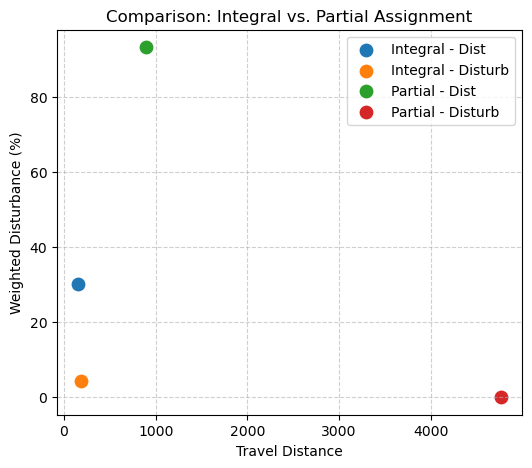

In [63]:
# Suppose from previous runs, we got integral min-distance solution:
int_min_dist_distance = 154.62
int_min_dist_disturb  = 30.138

# Suppose from previous runs, we got integral min-disturbance solution:
int_min_disb_distance = 188.89
int_min_disb_disturb  = 4.24

# Now from the partial model:
part_min_dist_distance = partial_dist_dist   # from partial-assignment (min distance)
part_min_dist_disturb  = partial_dist_disturb
part_min_disb_distance = partial_disb_dist
part_min_disb_disturb  = partial_disb_disturb

# Make a DataFrame of these four solutions:
compare_df = pd.DataFrame({
    "Model Type": ["Integral - Dist", "Integral - Disturb", 
                   "Partial - Dist",  "Partial - Disturb"],
    "Distance":   [int_min_dist_distance, int_min_disb_distance, 
                   part_min_dist_distance, part_min_disb_distance],
    "Disturbance":[int_min_dist_disturb,  int_min_disb_disturb, 
                   part_min_dist_disturb,  part_min_disb_disturb]
})

display(compare_df)

# Plot them
plt.figure(figsize=(6,5))

for idx, row in compare_df.iterrows():
    plt.scatter(row["Distance"], row["Disturbance"], s=80, label=row["Model Type"])

plt.xlabel("Travel Distance")
plt.ylabel("Weighted Disturbance (%)")
plt.title("Comparison: Integral vs. Partial Assignment")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.show()


## **Exercise**: 
If the demand increases uniformly in all bricks (for example + 25%, it will be necessary to hire a new sales representative. There is the question of where to locate his/her office (center brick).


### Solution

1. **Revised Data**  
   - We multiply each brick’s workload by 1.25 to reflect the higher demand.  
   - We maintain the same capacity constraints (e.g., each SR must have a total workload between 0.8 and 1.2).

2. **Expanding the Set of SRs**  
   We define the SR index set as  
   $$
   S = \{1,2,3,4,5,6\}.
   $$
   The new SR is labeled “6.”  

3. **Decision Variables**  
   - **Assignment**: $ x_{\text{sr}, j} \in \{0,1\} $ indicates whether Brick $j$ is assigned to SR $\text{sr}$.  
   - **Center**: $ c_{i,\text{sr}} \in \{0,1\} $ indicates whether Brick $i$ is the center for SR $\text{sr}$.  

   By introducing $\text{sr}=6$, we allow the model to use the new SR’s variables $\bigl(x_{6,j}, c_{i,6}\bigr)$ in the assignment and center selection.

4. **Objective: Minimize Total Distance**  
   The distance remains the principal metric:

   $$
   \min \;\; \sum_{\text{sr} \,\in\, S} \sum_{i=1}^{|\text{bricks}|} \sum_{j=1}^{|\text{bricks}|}
            \bigl(\text{distance}_{i,j}\bigr)\,x_{\text{sr},j}\,c_{i,\text{sr}}.
   $$

   - If SR 6 is used in the assignment, that usage is naturally captured by $x_{6,j}$ and $c_{i,6}$.  
   - If SR 6 remains effectively “unused,” the model can leave $x_{6,j} = 0$ for all $j$ and not choose any $c_{i,6}$.

5. **Key Constraints**

   1. **Unique Brick Assignment**  
      $$
      \sum_{\text{sr}\,\in\,S} x_{\text{sr}, j} = 1 
      \quad \forall j.
      $$
      Each brick $j$ must go to exactly one SR (possibly the new one).

   2. **Center Selection**  
      - Each SR chooses exactly one center:
        $$
        \sum_{i} c_{i,\text{sr}} = 1 
        \quad \forall \,\text{sr} \in S.
        $$
      - A brick $j$ assigned to $\text{sr}$ is only valid if that SR has some center:
        $$
        x_{\text{sr}, j} \;\le\; \sum_{i} c_{i,\text{sr}} 
        \quad \forall\, (\text{sr}, j).
        $$

   3. **Workload Bounds**  
      Each SR’s total workload must lie between 0.8 and 1.2 (after the +25% increase):
      $$
      0.8 \;\;\le\;\; \sum_{j} \bigl(\text{brick\_workload}[j]\bigr)\,x_{\text{sr}, j}
                    \;\;\le\;\; 1.2,
      \quad \forall\, \text{sr} \in S.
      $$
      This now applies to all 6 SRs.

6. **Outcome and Feasibility**  
   - If the existing 5 SRs can’t each stay within workload bounds, the new SR (SR 6) is **activated** in an optimal solution (i.e., $\sum_j x_{6,j} > 0$ and $\sum_i c_{i,6} = 1$).  
   - The model automatically **reassigns** bricks to keep every SR’s workload between 0.8 and 1.2, **choosing** whichever center for SR 6 that leads to minimal total distance.



In [64]:
# -------------------------------------------------
# 1) PROBLEM DATA
# -------------------------------------------------

# Bricks: 22 bricks labeled 1..22
bricks = list(range(1, 23))

# Sales Representatives (SRs): now allowing 6 (originally 5 + 1 new)
srs = list(range(1, 7))

# Generate random "base" workloads in [0.05, 0.1]
# Then scale them so that their sum is ~6.0,
# and finally multiply each by 1.25 to simulate +25% increased demand.
base_workload = {j: np.random.uniform(0.05, 0.1) for j in bricks}
sum_base = sum(base_workload.values())
target_total = 6.0  
scale_factor = target_total / sum_base

# Multiply each by the scale_factor, then by 1.25
brick_workload = {
    j: base_workload[j] * scale_factor * 1.25
    for j in bricks
}

# Print total final workload just for clarity
total_final_workload = sum(brick_workload.values())
print(f"Total (scaled +25%) workload over all bricks: {total_final_workload:.2f}")

# Distance matrix (simulated). Replace with real distances if available.
# distances[(i, j)] = distance from brick i to brick j
distances = {
    (i, j): float(np.random.randint(5, 50)) if i != j else 0.0
    for i in bricks
    for j in bricks
}

# Workload capacity bounds for each SR
min_workload = 0.8
max_workload = 1.2

# -------------------------------------------------
# 2) MODEL INITIALIZATION
# -------------------------------------------------

model = Model("SR_Expansion_RandomWorkload")

# Decision variables:
# x[sr, j] = 1 if brick j is assigned to SR 'sr', else 0
x = model.addVars(srs, bricks, vtype=GRB.BINARY, name="Assign")

# c[i, sr] = 1 if brick i is chosen as the center for SR 'sr'
c = model.addVars(bricks, srs, vtype=GRB.BINARY, name="Center")

# -------------------------------------------------
# 3) OBJECTIVE: MINIMIZE TOTAL DISTANCE
# -------------------------------------------------
# Sum of distances from center i to brick j, if j is assigned to sr and i is center of sr
model.setObjective(
    quicksum(
        distances[i, j] * x[sr, j] * c[i, sr]
        for sr in srs
        for i in bricks
        for j in bricks
    ),
    GRB.MINIMIZE
)

# -------------------------------------------------
# 4) CONSTRAINTS
# -------------------------------------------------

# (a) Each brick must be assigned exactly once
for j in bricks:
    model.addConstr(quicksum(x[sr, j] for sr in srs) == 1,
                    name=f"UniqueAssignment_Brick_{j}")

# (b) Each SR has exactly one center
for sr in srs:
    model.addConstr(quicksum(c[i, sr] for i in bricks) == 1,
                    name=f"OneCenter_SR_{sr}")

# (c) Workload constraints: each SR's total workload between min_workload and max_workload
for sr in srs:
    model.addConstr(
        quicksum(brick_workload[j] * x[sr, j] for j in bricks) >= min_workload,
        name=f"MinWorkload_SR_{sr}"
    )
    model.addConstr(
        quicksum(brick_workload[j] * x[sr, j] for j in bricks) <= max_workload,
        name=f"MaxWorkload_SR_{sr}"
    )

# (d) Linking assignment to center:
#     x[sr, j] <= sum(c[i, sr]) over i. 
#     i.e., if SR 'sr' is assigned to brick j, that SR must pick some center.
for sr in srs:
    for j in bricks:
        model.addConstr(
            x[sr, j] <= quicksum(c[i, sr] for i in bricks),
            name=f"AssignToCenter_{sr}_{j}"
        )

# -------------------------------------------------
# 5) SOLVE THE MODEL
# -------------------------------------------------
model.optimize()

# -------------------------------------------------
# 6) DISPLAY THE SOLUTION
# -------------------------------------------------
if model.status == GRB.OPTIMAL:
    print("\nOptimal Solution Found!")
    
    # Print which brick is the center for each SR
    for sr in srs:
        center_brick = [i for i in bricks if c[i, sr].X > 0.5]
        print(f"SR {sr}: Center Brick(s) = {center_brick}")

    # Print assignment of bricks to SRs
    for sr in srs:
        assigned_bricks = [j for j in bricks if x[sr, j].X > 0.5]
        workload_sum = sum(brick_workload[j] for j in assigned_bricks)
        print(f"SR {sr}: Assigned Bricks = {assigned_bricks}, Workload = {workload_sum:.3f}")
    
else:
    print(f"\nNo optimal solution found. (Status: {model.status})")

Total (scaled +25%) workload over all bricks: 7.50
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (26100.2))

CPU model: 12th Gen Intel(R) Core(TM) i5-1235U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 172 rows, 264 columns and 3564 nonzeros
Model fingerprint: 0x24003373
Model has 2772 quadratic objective terms
Variable types: 0 continuous, 264 integer (264 binary)
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [1e+01, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-01, 1e+00]
Presolve removed 132 rows and 0 columns
Presolve time: 0.02s
Presolved: 2812 rows, 3036 columns, 8844 nonzeros
Variable types: 0 continuous, 3036 integer (3036 binary)

Root relaxation: infeasible, 225 iterations, 0.01 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Exp

# Step 3: 
The location of the “center bricks” (SR offices) has a significant impact on the distance traveled by the
sales representatives. An important question is to generalize the model to allow a modification of the
“center bricks”.

## **Exercise**: 
Formulate a bi-objective optimization problem in which positions of offices are variables and in which the two objectives are the total distance (min), and the workload of SRs (MinMax).

### Bi-Objective Territory Assignment Model

When choosing **both** the **positions of centers** (offices) for Sales Representatives (SRs) *and* how bricks are assigned to these SRs, we can formulate a **bi-objective** problem with:
1. **Minimization of Total Distance**  
2. **Minimization of Workload Imbalance (MinMax)**

---

### Sets and Parameters

- **$S$**: Set of Sales Representatives, indexed by $i$.  
- **$B$**: Set of Bricks, indexed by $j$.  
- **$D_{k,j}$**: Distance between Brick $k$ and Brick $j$.  
- **$W_j$**: Workload of Brick $j$.

---

### Decision Variables

1. **$x_{i,j} \in \{0,1\}$**  
   Indicates whether Brick $j$ is assigned to SR $i$.  
   - $x_{i,j} = 1$ if Brick $j$ is assigned to SR $i$.  
   - $x_{i,j} = 0$ otherwise.

2. **$c_{k,i} \in \{0,1\}$**  
   Indicates whether Brick $k$ is **the center** for SR $i$.  
   - $c_{k,i} = 1$ if Brick $k$ is the center of SR $i$.  
   - $c_{k,i} = 0$ otherwise.  
   By constraining exactly one center per SR, each SR chooses exactly one Brick to be its office location.

3. **Workload Bounds**  
   - $\text{max\_workload}\ \ge 0$  
   - $\text{min\_workload}\ \ge 0$  
   These two real variables capture the maximum and minimum workload among all SRs.

---

### Objective Functions

#### Objective 1: Minimize Total Distance

We consider the distance between each **brick** $j$ and the **center** $k$ of the SR $i$. A direct representation is:

$$
\min \sum_{i \in S} \sum_{j \in B} \sum_{k \in B} 
\Bigl( D_{k,j} \cdot x_{i,j} \cdot c_{k,i} \Bigr).
$$

- $D_{k,j}$ is the distance from Brick $k$ (candidate center) to Brick $j$.  
- $x_{i,j} = 1$ if Brick $j$ is assigned to SR $i$.  
- $c_{k,i} = 1$ if Brick $k$ is the center for SR $i$.  

Hence, distance $D_{k,j}$ is added **only** when SR $i$ has $k$ as center *and* Brick $j$ is assigned to SR $i$.

#### Objective 2: Minimize Workload Imbalance (MinMax)

We want to **balance** the workloads across SRs. Define:

- $\text{max\_workload}$ = largest workload among all SRs,  
- $\text{min\_workload}$ = smallest workload among all SRs.

We minimize:

$$
\min \ \text{max\_workload} \;-\; \text{min\_workload}.
$$

This forces the heaviest-loaded SR and the lightest-loaded SR to be closer in total workload, improving balance.

---

### Constraints

1. **Unique Assignment**  
   Each Brick $j$ is assigned to **exactly one** SR:

   $$
   \sum_{i \in S} x_{i,j} = 1, 
   \quad \forall j \in B.
   $$

2. **Exactly One Center per SR**  
   Each SR $i$ chooses **exactly one** Brick as its center:

   $$
   \sum_{k \in B} c_{k,i} = 1, 
   \quad \forall i \in S.
   $$

3. **Link Between Assignment and Having a Center**  
   A Brick $j$ can only be assigned to SR $i$ if SR $i$ has a center. Often we simply do:

   $$
   x_{i,j} \;\le\; \sum_{k \in B} c_{k,i}, 
   \quad \forall i \in S, \; \forall j \in B.
   $$
   
   Since $\sum_{k \in B} c_{k,i} = 1$ in principle, this ensures $x_{i,j}$ is allowed only if SR $i$ chose some center.

4. **Workload Bounds**  
   Let the workload of SR $i$ be 
   $\text{Workload}_i = \sum_{j \in B} W_j \, x_{i,j}.$

   We then impose:

   $$
   \text{max\_workload} \;\;\ge\;\; \text{Workload}_i,
   \quad \forall i \in S,
   $$

   $$
   \text{min\_workload} \;\;\le\;\; \text{Workload}_i,
   \quad \forall i \in S.
   $$

Minimizing $\text{max\_workload} - \text{min\_workload}$ tries to keep $\text{Workload}_i$ consistent across all SRs.

---

### Linearization Process

Guorbi solver only supports linear equations, which is not the case for $(x_{i,j} \cdot c_{k,i})$. Now, let's linearize the problem:

1. **Introduce** an additional binary variable, say $y_{i,j,k}$, such that  
   $$
   y_{i,j,k} \;=\; x_{i,j} \,\times\, c_{k,i}.
   $$

2. **Add** the following constraints for all $(i,j,k)$:
   $$
   \begin{cases}
   y_{i,j,k} \;\le\; x_{i,j},\\
   y_{i,j,k} \;\le\; c_{k,i},\\
   y_{i,j,k} \;\ge\; x_{i,j} + c_{k,i} - 1.
   \end{cases}
   $$

3. **Replace** in the objective function, using $y_{i,j,k}$ instead of $(x_{i,j} \cdot c_{k,i})$:
   $$
   \text{Distance Objective} \;=\;
   \sum_{i \in S} \sum_{j \in B} \sum_{k \in B} D_{k,j} \,y_{i,j,k}.
   $$

This ensures that $y_{i,j,k} = 1$ **only** if both $x_{i,j}$ and $c_{k,i}$ are 1, and 0 otherwise, preserving the meaning of the original product.

In [65]:
import numpy as np
from gurobipy import Model, GRB, quicksum

# --------------------------
# Problem Data
# --------------------------

# Sets
bricks = list(range(0, 22))  # 22 bricks
srs = list(range(1, 6))      # 5 Sales Representatives (SRs)

# Workload simulation
brick_workload = {j: np.random.uniform(0.05, 0.8) for j in bricks}  # Workload for each brick

# Distance matrix (22x22) - simulated values
D = np.random.randint(5, 50, (22, 22))

# --------------------------
# Optimization Model
# --------------------------

model = Model("Territory_Optimization")

# Decision variables
# x[i,j] = 1 if Brick j is assigned to SR i
x = model.addVars(srs, bricks, vtype=GRB.BINARY, name="Assign")

# c[j,i] = 1 if Brick j is chosen as the center for SR i
c = model.addVars(bricks, srs, vtype=GRB.BINARY, name="Center")

# d[i,j] = a continuous variable representing the actual distance
# from brick j to SR i's center
d = model.addVars(srs, bricks, vtype=GRB.CONTINUOUS, name="Distance")

# Auxiliary variables to minimize the workload difference
max_workload = model.addVar(name="MaxWorkload")
min_workload = model.addVar(name="MinWorkload")

# --------------------------
# Linearization Variables: y[i,j,k]
# y[i,j,k] = x[i,j] * c[k,i]
# i = SR index
# j = brick assigned to SR
# k = the brick potentially serving as SR's center
# --------------------------
y = model.addVars(srs, bricks, bricks, vtype=GRB.BINARY, name="Y")

# Linearization constraints:
for i in srs:
    for j in bricks:       # assigned brick
        for k in bricks:   # possible center
            model.addConstr(y[i, j, k] <= x[i, j],
                             name=f"Lin_Y_le_X_{i}_{j}_{k}")
            model.addConstr(y[i, j, k] <= c[k, i],
                             name=f"Lin_Y_le_C_{i}_{j}_{k}")
            model.addConstr(y[i, j, k] >= x[i, j] + c[k, i] - 1,
                             name=f"Lin_Y_ge_XplusC_{i}_{j}_{k}")

# --------------------------
# Objective 1: Minimize Total Distance
# --------------------------
#
# We want d[i,j] >= the sum of distances from brick j to k,
# weighted by y[i,j,k]. If y[i,j,k] = 1, that means
# (j is assigned to i) AND (k is the center for i).
#
for i in srs:
    for j in bricks:
        model.addConstr(
            d[i, j] >= quicksum(D[j, k] * y[i, j, k] for k in bricks),
            name=f"DistCalc_{i}_{j}"
        )

# The objective function is the total sum of d[i,j].
model.setObjectiveN(
    quicksum(d[i, j] for i in srs for j in bricks),
    index=0, priority=1
)

# --------------------------
# Objective 2: Minimize the Maximum Workload Difference
# --------------------------

# Calculate the workload for each SR i
workloads = {}
for i in srs:
    workloads[i] = quicksum(brick_workload[j] * x[i, j] for j in bricks)

# Constraints for max_workload and min_workload
for i in srs:
    model.addConstr(max_workload >= workloads[i], name=f"Max_Workload_{i}")
    model.addConstr(min_workload <= workloads[i], name=f"Min_Workload_{i}")

# Minimize (max_workload - min_workload)
model.setObjectiveN(
    max_workload - min_workload,
    index=1, priority=0
)

# --------------------------
# Constraints
# --------------------------

# 1. Each brick must be assigned to exactly one SR
for j in bricks:
    model.addConstr(
        quicksum(x[i, j] for i in srs) == 1,
        name=f"UniqueAssignment_{j}"
    )

# 2. Each SR must have exactly one center
for i in srs:
    model.addConstr(
        quicksum(c[j, i] for j in bricks) == 1,
        name=f"OneCenter_{i}"
    )

# 3. A brick can only be assigned if this SR has a center
for i in srs:
    for j in bricks:
        # x[i,j] <= sum(c[k,i]) for k in bricks
        # This is typically always =1 anyway since sum(c[k,i])=1, but kept for completeness
        model.addConstr(
            x[i, j] <= quicksum(c[k, i] for k in bricks),
            name=f"AssignToCenter_{i}_{j}"
        )

# --------------------------
# Solve the Model
# --------------------------
model.optimize()

# --------------------------
# Display the Solution
# --------------------------
if model.status == GRB.OPTIMAL:
    print("\nOptimal Solution Found!")
    
    print("Chosen Centers for each SR:")
    for i in srs:
        center_brick = [j for j in bricks if c[j, i].x > 0.5]
        print(f"SR {i}: Center {center_brick}")

    print("\nAssignment of Bricks to SRs:")
    for i in srs:
        assigned_bricks = [j for j in bricks if x[i, j].x > 0.5]
        print(f"SR {i}: Bricks {assigned_bricks}")

    print("\nMaximum Workload Difference:", max_workload.x - min_workload.x)
else:
    print("\nNo optimal solution found.")

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (26100.2))

CPU model: 12th Gen Intel(R) Core(TM) i5-1235U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 7517 rows, 2752 columns and 22450 nonzeros
Model fingerprint: 0x5912d5b6
Variable types: 112 continuous, 2640 integer (2640 binary)
Coefficient statistics:
  Matrix range     [9e-02, 5e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]

---------------------------------------------------------------------------
Multi-objectives: starting optimization with 2 objectives ... 
---------------------------------------------------------------------------

Multi-objectives: applying initial presolve ...
---------------------------------------------------------------------------

Presolve removed 110 rows and 0 columns
Presolve time: 0.03s
Presolved: 7407 rows, 2752 columns, 199

### Compute the sets of non-dominated solutions for the three-objective problem (total distance,workload fairness, and number of relocated offices)

In [66]:
# --------------------------
# Problem Data
# --------------------------

# Sets
bricks = list(range(0, 22))  # 22 bricks
srs = list(range(1, 6))      # 5 Sales Representatives (SRs)

# Workload simulation
brick_workload = {j: np.random.uniform(0.05, 0.8) for j in bricks}  # Workload for each brick

# Distance matrix (22x22) - simulated values
D = np.random.randint(5, 50, (22, 22))

# Initial SR centers (randomly chosen for baseline comparison)
initial_centers = {i: np.random.choice(bricks) for i in srs}

# --------------------------
# Optimization Model
# --------------------------

model = Model("Territory_Optimization")

# Decision variables
x = model.addVars(srs, bricks, vtype=GRB.BINARY, name="Assign")
c = model.addVars(bricks, srs, vtype=GRB.BINARY, name="Center")
d = model.addVars(srs, bricks, vtype=GRB.CONTINUOUS, name="Distance")

max_workload = model.addVar(name="MaxWorkload")
min_workload = model.addVar(name="MinWorkload")

# Linearization variables
y = model.addVars(srs, bricks, bricks, vtype=GRB.BINARY, name="Y")

# Linearization constraints
for i in srs:
    for j in bricks:
        for k in bricks:
            model.addConstr(y[i, j, k] <= x[i, j])
            model.addConstr(y[i, j, k] <= c[k, i])
            model.addConstr(y[i, j, k] >= x[i, j] + c[k, i] - 1)

# Distance constraints
for i in srs:
    for j in bricks:
        model.addConstr(d[i, j] >= quicksum(D[j, k] * y[i, j, k] for k in bricks))

# Objective 1: Minimize Total Distance
model.setObjectiveN(quicksum(d[i, j] for i in srs for j in bricks), index=0, priority=1)

# Objective 2: Minimize Workload Difference
workloads = {i: quicksum(brick_workload[j] * x[i, j] for j in bricks) for i in srs}
for i in srs:
    model.addConstr(max_workload >= workloads[i])
    model.addConstr(min_workload <= workloads[i])
model.setObjectiveN(max_workload - min_workload, index=1, priority=0)

# Objective 3: Minimize Number of Relocated Offices
relocated = model.addVars(srs, vtype=GRB.BINARY, name="Relocated")
for i in srs:
    model.addConstr(relocated[i] >= quicksum(c[j, i] for j in bricks if j == initial_centers[i]) - 1)
model.setObjectiveN(quicksum(relocated[i] for i in srs), index=2, priority=-1)

# Constraints
for j in bricks:
    model.addConstr(quicksum(x[i, j] for i in srs) == 1)
for i in srs:
    model.addConstr(quicksum(c[j, i] for j in bricks) == 1)
    for j in bricks:
        model.addConstr(x[i, j] <= quicksum(c[k, i] for k in bricks))

# Solve
model.optimize()

# Display Solutions
if model.status == GRB.OPTIMAL:
    print("\nOptimal Solution Found!")
    print("Chosen Centers for each SR:")
    for i in srs:
        center_brick = [j for j in bricks if c[j, i].x > 0.5]
        print(f"SR {i}: Center {center_brick}")
    print("\nAssignment of Bricks to SRs:")
    for i in srs:
        assigned_bricks = [j for j in bricks if x[i, j].x > 0.5]
        print(f"SR {i}: Bricks {assigned_bricks}")
    print("\nRelocated Offices:", sum(relocated[i].x for i in srs))
    print("Maximum Workload Difference:", max_workload.x - min_workload.x)
else:
    print("\nNo optimal solution found.")


Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (26100.2))

CPU model: 12th Gen Intel(R) Core(TM) i5-1235U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 7522 rows, 2757 columns and 22460 nonzeros
Model fingerprint: 0xae722e69
Variable types: 112 continuous, 2645 integer (2645 binary)
Coefficient statistics:
  Matrix range     [6e-02, 5e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]

---------------------------------------------------------------------------
Multi-objectives: starting optimization with 3 objectives ... 
---------------------------------------------------------------------------

Multi-objectives: applying initial presolve ...
---------------------------------------------------------------------------

Presolve removed 115 rows and 0 columns
Presolve time: 0.03s
Presolved: 7407 rows, 2757 columns, 199

# Step 4

## **Exercise**:
In the first three steps, the question tackled relates to the computation of non-dominated solutions for the assignment (or assignment-relocation) problem. The choice of a specific solution in the set of non-dominated solutions is yet to be made. In this third step, you are asked to develop an additive preference model (using the UTA method) to support the choice among solutions for the three criteria problem (total distance, workload fairness, and number of relocated offices). To simulate the preferences of the decision maker used as input in the UTA method, you will randomly generate and use a piecewise linear additive model.

---

# Applying an Additive Preference Model (UTA) to Evaluate Non-Dominated Solutions

In **multi-criteria decision-making**, we often generate a set of **non-dominated** (or **Pareto optimal**) solutions rather than a single “best” one. The challenge is then to **select** a single solution—or a small set of promising ones—from this set, according to the **decision-maker’s** (DM’s) actual preferences. The **UTA (UTilités Additives)** method offers a way to build and apply an **additive preference model** to guide that choice. Here is an overview of how it works:

---

## 1. **Non-Dominated Solutions**

First, we assume we have a set of **non-dominated solutions**, each one optimizing multiple **conflicting** criteria (e.g., **distance**, **workload fairness**, and **relocated offices**). In real applications, these solutions might come from a **multi-objective optimization** process. For demonstration, we can **simulate** them by assigning random values within plausible ranges.

---

## 2. **Piecewise Linear Utility Functions**

A **utility function** translates a specific criterion value (like “total distance”) into a **preference** measure. If the DM’s preferences are *non-linear*, a **piecewise linear** approach can approximate them flexibly. Thus, for each criterion:
1. We define a series of **breakpoints** (subranges) in the criterion’s scale.  
2. We specify the **utility** at each breakpoint, creating a **piecewise linear** shape.  

In practice, these utility functions would be **elicited** from the DM, but here we may generate them **randomly** to simulate arbitrary preferences.

---

## 3. **Transforming Criteria into Utility**

To evaluate how good a solution is for each criterion:
1. **Normalize** the criterion’s value for that solution into a [0,1] scale.  
2. **Interpolate** the normalized value into the piecewise utility function, obtaining a **utility** score between 0 and 1 (or another relevant range).  

This step is repeated for **all** criteria.

---

## 4. **Combining Utilities (Additive Model)**

An **additive** preference model sums the **per-criterion** utilities. Formally, if we have three criteria, each solution’s total utility is:
$$
U(\text{Solution}) \;=\; U_{1}(\text{Criterion}_1) \;+\; U_{2}(\text{Criterion}_2) \;+\; U_{3}(\text{Criterion}_3),
$$
where $U_{k}$ is the utility function for the $k$-th criterion. Solutions with **higher** total utility are **more** preferred by this additive model.

---

## 5. **Selecting the Best Solution**

After computing a **total utility** for each non-dominated solution, we can:
- Rank all solutions by their total utility, or
- Simply **pick** the solution with the **highest** total utility as the “best” in the eyes of this UTA model.

In a real decision process, the DM might:
1. Validate the **utility functions** against their true preferences,  
2. Study the **top** solutions (e.g., top 3 or 5) to see if any additional constraints or qualitative factors favor one option over another.

---

## 6. **Benefits of This Approach**

- **Bridges Multi-Objective and Choice**: The UTA method provides a **systematic** way to pick or rank solutions from a **Pareto set**, avoiding ad hoc selection.  
- **Flexible Preference Modeling**: By using **piecewise linear** functions, we can capture **non-linear** preference structures.  
- **Clear Interpretation**: An additive model is **easy** to explain: each criterion contributes an **independent** piece of utility, summed into a single score.

---

## 7. **Conclusion**

The UTA method is an **effective** tool for translating a **set of non-dominated solutions** into a **single** or **ranked** outcome reflecting the **decision-maker’s** priorities across multiple criteria. Even if we simulate preferences and non-dominated solutions in a demonstration, the **same** principles apply when real solutions and **expert** preferences are at play. This final step ensures that the **best** solution (or small subset of top solutions) is chosen in line with the DM’s **actual** preferences.


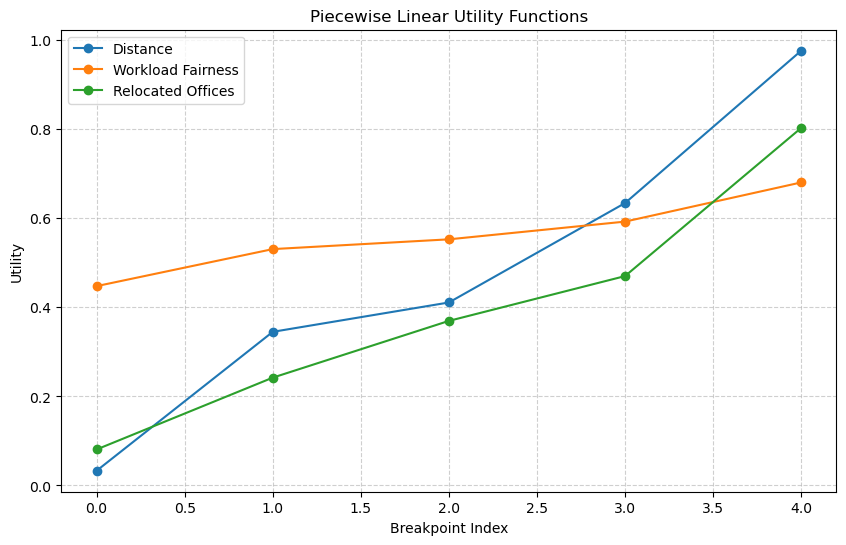

Evaluated Solutions:
       Distance  Workload Fairness  Relocated Offices   Utility
0   174.908024          19.391693                  7  1.522286
1   290.142861          15.502656                  1  1.634531
2   246.398788          18.789979                  4  1.603415
3   219.731697          17.896547                  4  1.461930
4   131.203728          11.958000                  5  1.150153
5   131.198904          18.437485                  7  1.338760
6   111.616722           1.769850                  7  1.028555
7   273.235229           3.919657                  4  1.645259
8   220.223002           0.904546                  7  1.442193
9   241.614516           6.506607                  3  1.391052
10  104.116899           7.773546                  6  0.996297
11  293.981970           5.426981                  2  1.670890
12  266.488528          16.574750                  9  2.205483
13  142.467822           7.135067                  5  1.195218
14  136.364993           5.618690

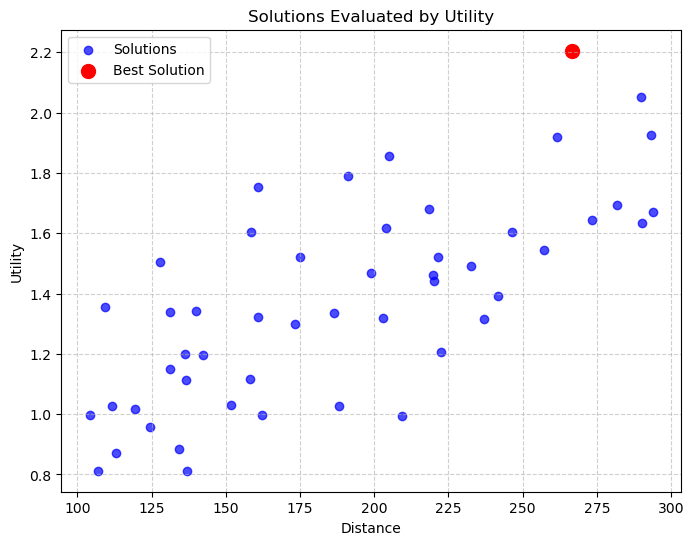

In [67]:
# Step 1: Generate simulated non-dominated solutions
def generate_non_dominated_solutions(n_solutions=50):
    """
    Simulate a set of non-dominated solutions for the three criteria.
    Each solution has values for distance, workload fairness, and relocated offices.
    """
    np.random.seed(42)
    total_distance = np.random.uniform(100, 300, n_solutions)  # Random distances
    workload_fairness = np.random.uniform(0, 20, n_solutions)  # Random fairness measures
    relocated_offices = np.random.randint(1, 10, n_solutions)  # Random office relocations
    
    solutions = pd.DataFrame({
        "Distance": total_distance,
        "Workload Fairness": workload_fairness,
        "Relocated Offices": relocated_offices
    })
    return solutions

non_dominated_solutions = generate_non_dominated_solutions()

# Step 2: Generate a random piecewise linear additive utility model
def generate_utility_functions(n_criteria=3, n_breakpoints=5):
    """
    Generate random piecewise linear utility functions for each criterion.
    Each utility is defined by `n_breakpoints` linear pieces.
    """
    utilities = []
    for _ in range(n_criteria):
        # Generate breakpoints (sorted values) and corresponding utility levels
        breakpoints = np.sort(np.random.uniform(0, 1, n_breakpoints))
        utilities.append(breakpoints)
    return utilities

utility_functions = generate_utility_functions()

# Visualize utility functions
def plot_utility_functions(utility_functions, labels):
    plt.figure(figsize=(10, 6))
    for i, utility in enumerate(utility_functions):
        plt.plot(range(len(utility)), utility, marker="o", label=labels[i])
    plt.xlabel("Breakpoint Index")
    plt.ylabel("Utility")
    plt.title("Piecewise Linear Utility Functions")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()

plot_utility_functions(utility_functions, ["Distance", "Workload Fairness", "Relocated Offices"])

# Step 3: Apply the UTA method to evaluate solutions
def apply_uta(solutions, utility_functions):
    """
    Evaluate each solution using the UTA method with given utility functions.
    Normalize each criterion and compute a weighted sum of utilities.
    """
    # Normalize solutions for each criterion to [0, 1]
    normalized_solutions = solutions.copy()
    for col in solutions.columns:
        normalized_solutions[col] = (
            (solutions[col] - solutions[col].min()) /
            (solutions[col].max() - solutions[col].min())
        )
    
    # Compute utility for each solution
    total_utilities = []
    for _, row in normalized_solutions.iterrows():
        utility = 0
        for i, criterion in enumerate(row):
            utility += np.interp(criterion, np.linspace(0, 1, len(utility_functions[i])), utility_functions[i])
        total_utilities.append(utility)
    
    solutions["Utility"] = total_utilities
    return solutions

evaluated_solutions = apply_uta(non_dominated_solutions, utility_functions)

# Step 4: Select the best solution
best_solution = evaluated_solutions.loc[evaluated_solutions["Utility"].idxmax()]

# Display results
print("Evaluated Solutions:\n", evaluated_solutions)
print("\nBest Solution:\n", best_solution)

# Visualize evaluated solutions
plt.figure(figsize=(8, 6))
plt.scatter(evaluated_solutions["Distance"], evaluated_solutions["Utility"], label="Solutions", c="blue", alpha=0.7)
plt.scatter(best_solution["Distance"], best_solution["Utility"], color="red", label="Best Solution", s=100)
plt.xlabel("Distance")
plt.ylabel("Utility")
plt.title("Solutions Evaluated by Utility")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()
